In [70]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from matplotlib.image import imread
import pandas as pd
from PIL import Image
import cv2
import zipfile
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
import warnings
from imblearn.over_sampling import SMOTE

In [71]:
# running locally for now

#from google.colab import drive
#drive.mount('/content/drive')

In [72]:
#zip_path = 'drive/MyDrive/CSE 151A Final Project/FracAtlas.zip'
zip_path = 'FracAtlas.zip'
extract_dir = 'fracatlas_extracted'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

images_dir = os.path.join(extract_dir, 'FracAtlas/images')
annotations_dir = os.path.join(extract_dir, 'FracAtlas/Annotations/YOLO')
# Checked to see if each image has a corresponding label

categories = ['Fractured', 'Non_fractured']

for cat in categories:
    category_path = os.path.join(images_dir, cat)

    for img_file in os.listdir(category_path):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_name = os.path.splitext(img_file)[0]
            annotation_file = img_name + '.txt'
            annotation_path = os.path.join(annotations_dir, annotation_file)

In [73]:
images_dir = 'fracatlas_extracted/FracAtlas/images'
annotations_dir = 'fracatlas_extracted/FracAtlas/Annotations/YOLO'

images = []
labels = []

for category in os.listdir(images_dir):
    category_path = os.path.join(images_dir, category)

    if not os.path.isdir(category_path):
        continue

    for img_file in os.listdir(category_path):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_name = os.path.splitext(img_file)[0]
            annotation_file = img_name + '.txt'
            annotation_path = os.path.join(annotations_dir, annotation_file)

            if os.path.exists(annotation_path):
                img_path = os.path.join(category_path, img_file)
                images.append(img_path)
                labels.append(category)
            else:
                print(f"No annotation found for {img_file} at {annotation_path}.")

data_dict_old = {
    "inputs": images,
    "labels": labels
}

print(f"{len(images)} image paths and {len(labels)} labels in organized data")

4083 image paths and 4083 labels in organized data


In [74]:
def preprocess(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0 # normalize pixel values
        return img_array
    except (OSError, IOError) as e:
        warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
        return None

images = []
labels = []

for img_path, label in zip(data_dict_old["inputs"], data_dict_old["labels"]):
    img = preprocess(img_path)
    if img is not None:
        images.append(img)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

data_dict = {
    "inputs": images,
    "labels": labels
}

print(f"{len(images)}/{len(data_dict_old['inputs'])} images processed")

C:\Users\Owner\AppData\Local\Temp\ipykernel_20228\119297130.py:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images\Non_fractured\IMG0004028.jpg. Error: image file is truncated (20 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
C:\Users\Owner\AppData\Local\Temp\ipykernel_20228\119297130.py:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images\Non_fractured\IMG0004029.jpg. Error: image file is truncated (22 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
C:\Users\Owner\AppData\Local\Temp\ipykernel_20228\119297130.py:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images\Non_fractured\IMG0004036.jpg. Error: image file is truncated (14 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
C:\Users\Owner\AppData\Local\Temp\ipykernel_20228\119297130.py:8: UserWarning: Skipping corrupted image: frac

4024/4083 images processed


In [75]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data_dict["labels"])
data_dict["encoded_labels"] = encoded_labels
# Function to convert image to grayscale
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function to normalize pixel values to [0, 1]
def normalize(image):
    return image / 255.0

# Function to standardize the image data, mean=0 and std=1
def standardize(image):
    mean = np.mean(image)
    std = np.std(image)
    standardized_image = (image - mean) / std
    return standardized_image
# Convert images to grayscale and save
def convert_and_save_grayscale_images(folder_path, save_folder, target_size=(224, 224)):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)  # Make sure save folder exists

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        # Skip over corrupt images
        if image is None:
            warnings.warn(f"Skipping corrupt or unreadable image: {image_path}")
            continue

        image_resized = cv2.resize(image, target_size)

        # Convert to grayscale
        grayscale_image = convert_to_grayscale(image_resized)

        # Save the grayscale image
        processed_image_path = os.path.join(save_folder, f"grayscale_{i}.npy")
        np.save(processed_image_path, grayscale_image)

        # Free up memory
        del image, grayscale_image

    print("Grayscale conversion completed.")

# Normalize the grayscale images
def normalize_and_save_images(folder_path, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.npy')]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        grayscale_image = np.load(image_path)

        # Normalize the grayscale image
        normalized_image = normalize(grayscale_image)

        # Save the normalized image
        processed_image_path = os.path.join(save_folder, f"normalized_{i}.npy")
        np.save(processed_image_path, normalized_image)
    print("Normalization completed.")

# Standardize the normalized images
def standardize_and_save_images(folder_path, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.npy')]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        normalized_image = np.load(image_path)

        # Standardize the normalized image
        standardized_image = standardize(normalized_image)

        # Save the standardized image
        processed_image_path = os.path.join(save_folder, f"standardized_{i}.npy")
        np.save(processed_image_path, standardized_image)

        # Free up memory
        del normalized_image, standardized_image

    print("Standardization completed.")

In [76]:
!ls fracatlas_extracted/FracAtlas/images/

!ls 'fracatlas_extracted/FracAtlas/images/Fractured'

'ls' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [77]:
#frac_path = '/content/Processed/Final/Processed_Fractured_Final'
#unfrac_path = '/content/Processed/Final/Processed_Non_Fractured_Final'
frac_path = 'Processed/Final/Processed_Fractured_Final'
unfrac_path = 'Processed/Final/Processed_Non_Fractured_Final'

In [78]:
fractured_path = 'fracatlas_extracted/FracAtlas/images/Fractured'
non_fractured_path = 'fracatlas_extracted/FracAtlas/images/Non_fractured'

# Folders to save the processed images for fractured and non-fractured
grayscale_fractured_folder = 'Processed/Grayscale/Processed_Fractured_Grayscale'
grayscale_non_fractured_folder = 'Processed/Grayscale/Processed_Non_Fractured_Grayscale'

normalized_fractured_folder = 'Processed/Normalize/Processed_Fractured_Normalized'
normalized_non_fractured_folder = 'Processed/Normalize/Processed_Non_Fractured_Normalized'

standardized_fractured_folder = 'Processed/Final/Processed_Fractured_Final'
standardized_non_fractured_folder = 'Processed/Final/Processed_Non_Fractured_Final'

In [79]:
# Convert all fractured and non-fractured images to grayscale and save
convert_and_save_grayscale_images(fractured_path, grayscale_fractured_folder)
convert_and_save_grayscale_images(non_fractured_path, grayscale_non_fractured_folder)

# Normalize grayscale images for both fractured and non-fractured categories
normalize_and_save_images(grayscale_fractured_folder, normalized_fractured_folder)
normalize_and_save_images(grayscale_non_fractured_folder, normalized_non_fractured_folder)

# Standardize normalized images for both fractured and non-fractured categories
standardize_and_save_images(normalized_fractured_folder, standardized_fractured_folder)
standardize_and_save_images(normalized_non_fractured_folder, standardized_non_fractured_folder)

print("All preprocessing steps completed for both fractured and non-fractured images.")

Grayscale conversion completed.
Grayscale conversion completed.
Normalization completed.
Normalization completed.
Standardization completed.
Standardization completed.
All preprocessing steps completed for both fractured and non-fractured images.


In [80]:
# load fractured and unfractured images into arrays
fracArr = []
unfracArr = []
for file in os.listdir(frac_path):
  if file.endswith(".npy"):
    fracArr.append(np.load(os.path.join(frac_path, file)))
for file in os.listdir(unfrac_path):
  if file.endswith(".npy"):
    unfracArr.append(np.load(os.path.join(unfrac_path, file)))

In [81]:
# combine images and true/false values into one array
dataset = []
data_extra = []
for i in range(len(fracArr)):
  dataset.append([fracArr[i], True])
  dataset.append([unfracArr[i], False])
for i in range(len(fracArr), len(unfracArr)):
  data_extra.append([unfracArr[i], False])

In [82]:
# get X and y arrays from the dataset
dataset = np.array(dataset, dtype=object)
X = dataset[:,0]
y = dataset[:,1].astype('bool')

In [83]:
# shuffle and split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=3**-2, random_state=42)

In [84]:
# append the extra unfractured images to the training dataset
data_extra = np.array(data_extra, dtype=object)
data_train = np.column_stack((X_train, y_train))
data_train = np.append(data_train, data_extra, axis=0)
random.seed(42)
random.shuffle(data_train)
X_train = data_train[:,0]
y_train = [bool(d) for d in data_train[:,1]]

In [85]:
# reshape array to use with smote
shape_orig = X_train[0].shape
X_train = np.array([np.array(val).flatten() for val in X_train])

# oversample to fix class imbalance in the training set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# build flattened array
X_train = np.array([np.array(val).reshape(shape_orig) for val in X_train])

In [86]:
# flatten the other arrays
X_val = np.array([np.array(val) for val in X_val])
X_test = np.array([np.array(val) for val in X_test])
y_train = np.array([np.array(val) for val in y_train])
y_val = np.array([np.array(val) for val in y_val])
y_test = np.array([np.array(val) for val in y_test])

In [87]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4932, 224, 224)
(4932,)
(144, 224, 224)
(144,)
(144, 224, 224)
(144,)


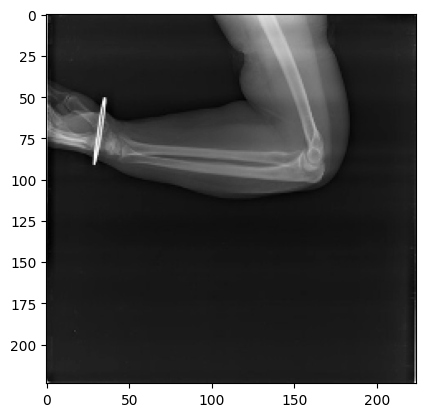

Fracture present: False


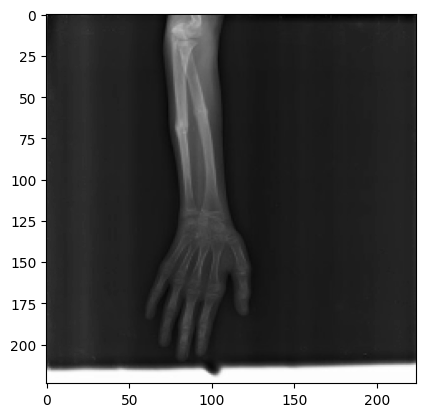

Fracture present: True


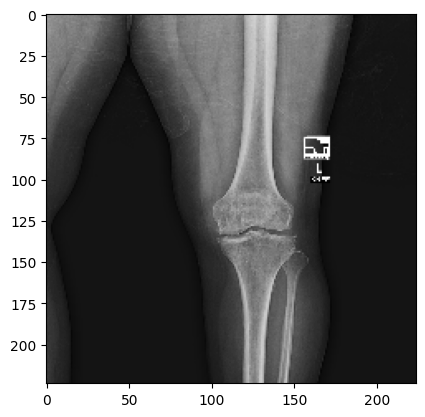

Fracture present: False


In [88]:
# print some random examples from the training set
arr = random.sample(range(0, len(X_train)), 3)
for i in arr:
  plt.imshow(X_train[i], cmap='gray')
  plt.show()
  print("Fracture present:", y_train[i])

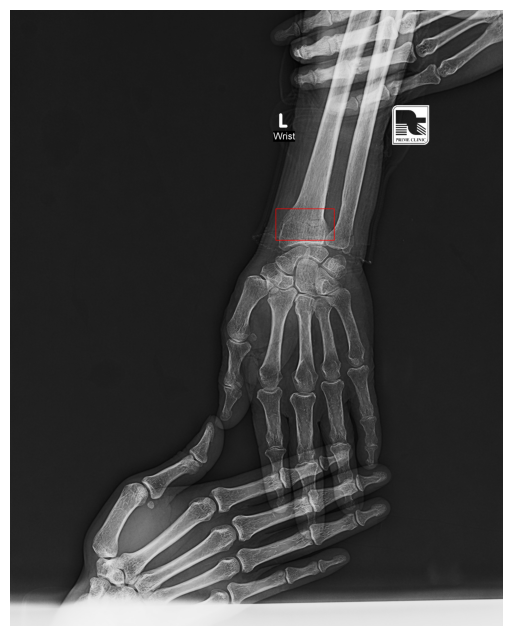

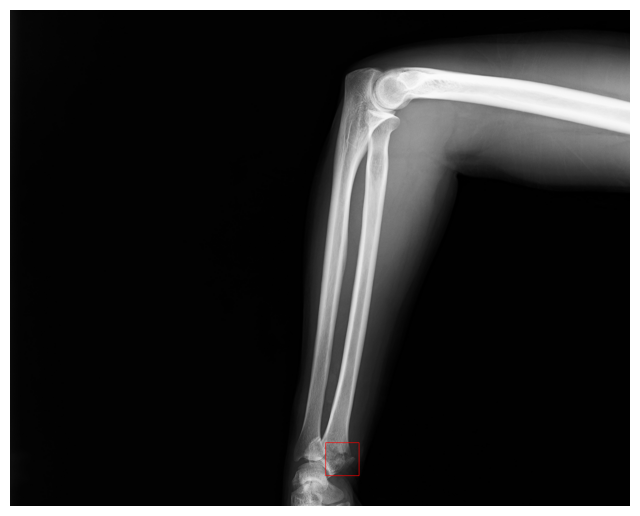

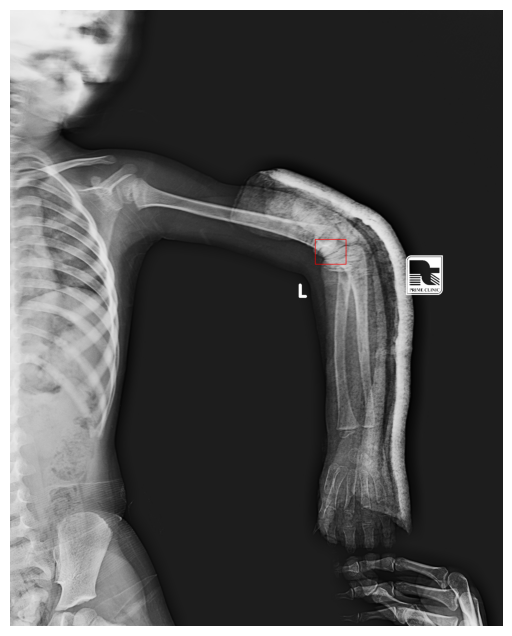

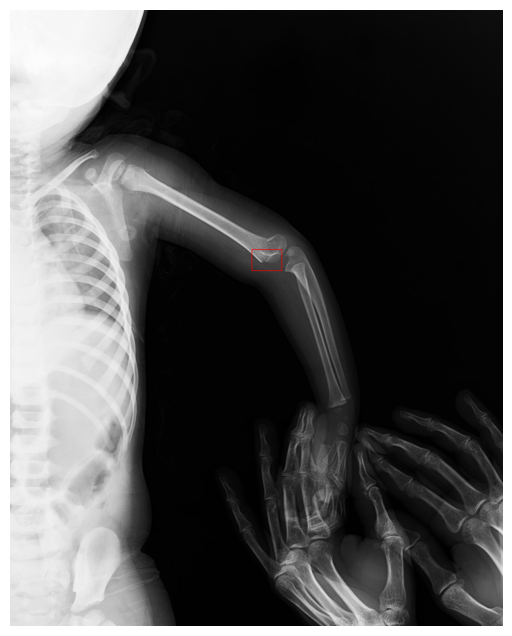

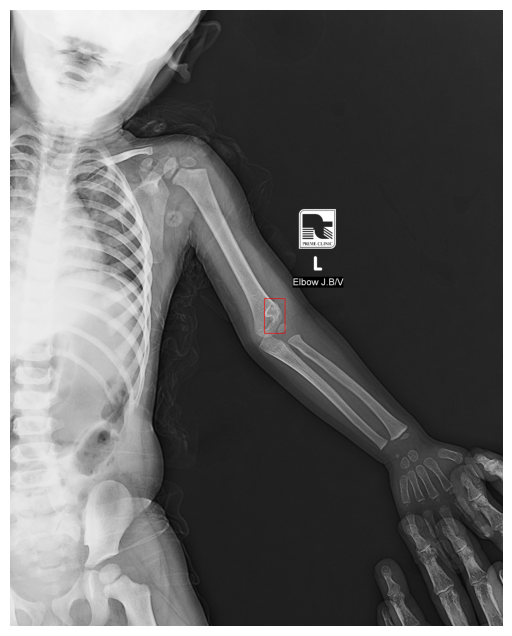

In [89]:
# Function to overlay bounding boxes on images
def draw_bounding_boxes(img_path, annotation_path, save_dir=None):
    # Loading the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = img.shape

    # Checking if annotation exists
    if not os.path.exists(annotation_path):
        warnings.warn(f"Annotation file {annotation_path} not found. Skipping.")
        return None

    # Reading YOLO annotations
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:

        # YOLO format: class_id, x_center, y_center, width, height (all relative)
        parts = line.strip().split()
        if len(parts) != 5:
            warnings.warn(f"Invalid annotation format in {annotation_path}. Skipping.")
            continue

        class_id, x_center, y_center, width, height = map(float, parts)

        # Converting relative coordinates to absolute pixel values
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculating box corners
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, os.path.basename(img_path))
        plt.imsave(save_path, img)

    plt.show()

for img_path, label in zip(data_dict_old["inputs"][:5], data_dict_old["labels"][:5]):

    img_name = os.path.splitext(os.path.basename(img_path))[0]
    annotation_path = os.path.join(annotations_dir, img_name + '.txt')

    draw_bounding_boxes(img_path, annotation_path)

In [90]:
import tensorflow.keras as keras

In [91]:
cnn_model = keras.Sequential()

# 2. Create the input layer and add it to the model object:
input_layer = keras.layers.InputLayer(input_shape = (224, 224, 1))
cnn_model.add(input_layer)

# 3. Create the first convolutional layer and add it to the model object:
conv_1 = keras.layers.Conv2D(filters=16, kernel_size=3)
batchNorm_1 = keras.layers.BatchNormalization()
ReLU_1 = keras.layers.ReLU()
cnn_model.add(conv_1)
cnn_model.add(batchNorm_1)
cnn_model.add(ReLU_1)

# 4. Create the second convolutional layer and add it to the model object:
conv_2 = keras.layers.Conv2D(filters=32, kernel_size=3)
batchNorm_2 = keras.layers.BatchNormalization()
ReLU_2= keras.layers.ReLU()
cnn_model.add(conv_2)
cnn_model.add(batchNorm_2)
cnn_model.add(ReLU_2)

# 5. Create the third convolutional layer and add it to the model object:
conv_3 = keras.layers.Conv2D(filters=64, kernel_size=3)
batchNorm_3 = keras.layers.BatchNormalization()
ReLU_3 = keras.layers.ReLU()
cnn_model.add(conv_3)
cnn_model.add(batchNorm_3)
cnn_model.add(ReLU_3)

# 7. Create the pooling layer and add it to the model object:
pooling_layer = keras.layers.GlobalAveragePooling2D()
cnn_model.add(pooling_layer)
# 8. Create the output layer and add it to the model object:
output_layer = keras.layers.Dense(units=10)
cnn_model.add(output_layer)

cnn_model.summary()

C:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 222, 222, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 220, 220, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 220, 220, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 218, 218, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 218, 218, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 218, 218, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,394 (95.29 KB)

 Trainable params: 24,170 (94.41 KB)

 Non-trainable params: 224 (896.00 B)

In [92]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [93]:
sgd_optimizer = keras.optimizers.SGD(learning_rate = 0.1)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
cnn_model.compile(optimizer=sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

In [94]:
num_epochs = 5 # Number of epochs


history = cnn_model.fit(X_train, y_train, epochs=num_epochs, batch_size=64)

Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - accuracy: 0.4842 - loss: 1.0466
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - accuracy: 0.5548 - loss: 0.6931
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 374s 5s/step - accuracy: 0.5929 - loss: 0.6797
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - accuracy: 0.6190 - loss: 0.6667
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 379s 5s/step - accuracy: 0.6034 - loss: 0.6643


In [95]:
train_loss, train_accuracy = cnn_model.evaluate(X_train, y_train)
print("Evaluated performance on the training set.")
print('Loss:', str(train_loss) , 'Accuracy:', str(train_accuracy))

155/155 ━━━━━━━━━━━━━━━━━━━━ 68s 439ms/step - accuracy: 0.5374 - loss: 0.8041
Evaluated performance on the training set.
Loss: 0.8403832316398621 Accuracy: 0.5024330615997314


In [96]:
val_loss, val_accuracy = cnn_model.evaluate(X_val, y_val)
print("Evaluated performance on the validation set.")
print('Loss:', str(val_loss) , 'Accuracy:', str(val_accuracy))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 0.4970 - loss: 0.7966
Evaluated performance on the validation set.
Loss: 0.7648861408233643 Accuracy: 0.5208333134651184


In [97]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print("Evaluated performance on the testing set.")
print('Loss:', str(test_loss) , 'Accuracy:', str(test_accuracy))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.5849 - loss: 0.7732
Evaluated performance on the testing set.
Loss: 0.7497978210449219 Accuracy: 0.5972222089767456


In [98]:
# Make predictions on the training set
logits_train = cnn_model.predict(X_train)
predictions_train = logits_train.argmax(axis = 1).astype('bool')

155/155 ━━━━━━━━━━━━━━━━━━━━ 70s 451ms/step


In [99]:
# Make predictions on the validation set
logits_val = cnn_model.predict(X_val)
predictions_val = logits_val.argmax(axis = 1).astype('bool')

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step


In [100]:
# Make predictions on the test set
logits_test = cnn_model.predict(X_test)
predictions_test = logits_test.argmax(axis = 1).astype('bool')

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step


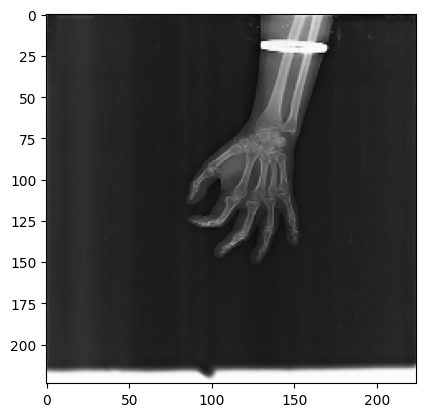

Ground truth: False
Prediction: False


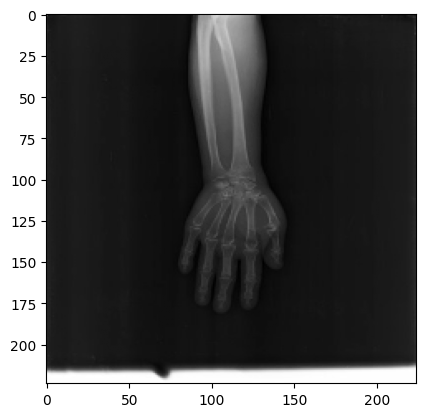

Ground truth: True
Prediction: False


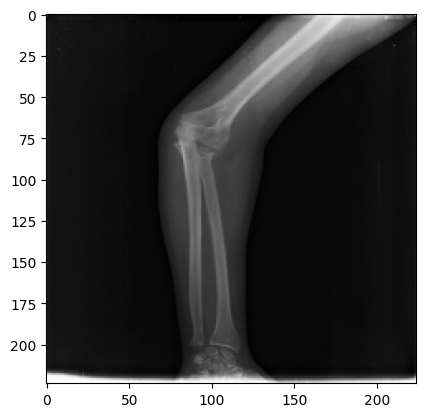

Ground truth: True
Prediction: False


In [101]:
# print sample predictions for the training set
arr = random.sample(range(0, len(X_train)), 3)
for i in arr:
  plt.imshow(X_train[i], cmap='gray')
  plt.show()
  print("Ground truth:", y_train[i])
  print("Prediction:", predictions_train[i])

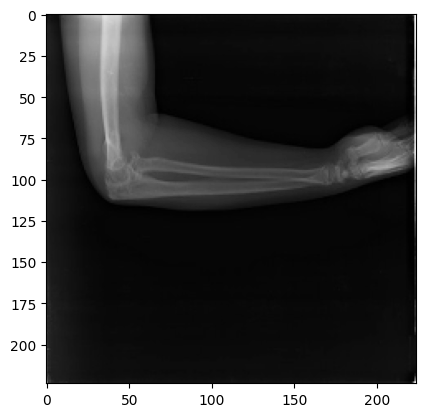

Ground truth: True
Prediction: False


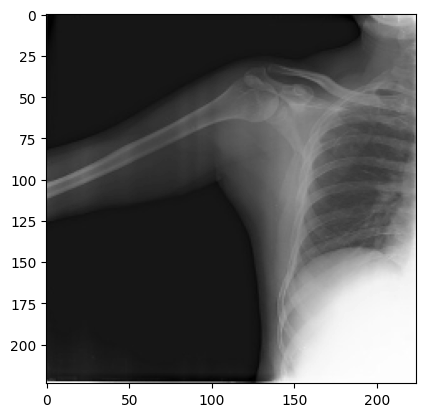

Ground truth: False
Prediction: False


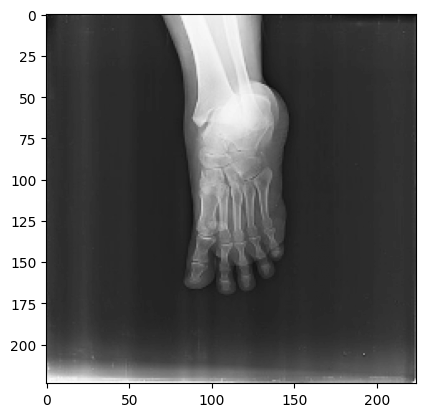

Ground truth: False
Prediction: False


In [102]:
# print sample predictions for the validation set
arr = random.sample(range(0, len(X_val)), 3)
for i in arr:
  plt.imshow(X_val[i], cmap='gray')
  plt.show()
  print("Ground truth:", y_val[i])
  print("Prediction:", predictions_val[i])

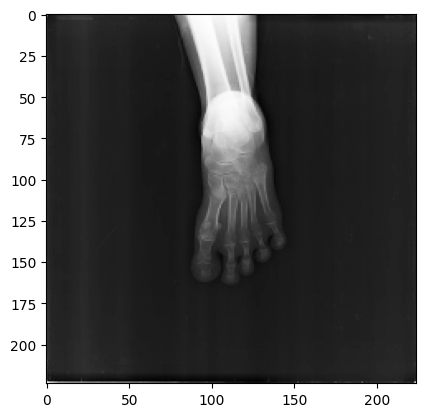

Ground truth: False
Prediction: False


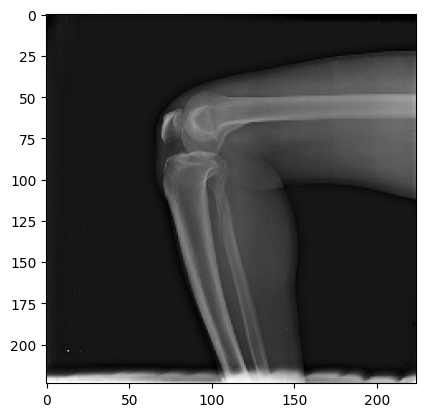

Ground truth: True
Prediction: False


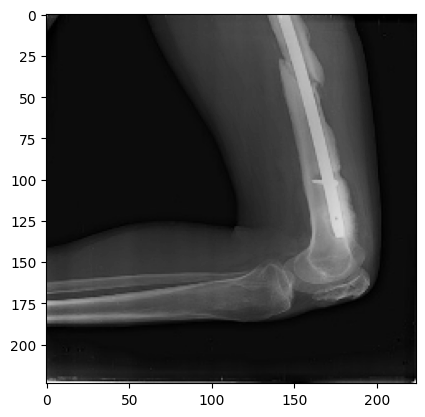

Ground truth: True
Prediction: False


In [103]:
# print sample predictions for the testing set
arr = random.sample(range(0, len(X_test)), 3)
for i in arr:
  plt.imshow(X_test[i], cmap='gray')
  plt.show()
  print("Ground truth:", y_test[i])
  print("Prediction:", predictions_test[i])